In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

le = LabelEncoder()

# Pulling in our dataset

Here we have our dataset of historic NBA Draft Prospect data. The data consists of stats from their whole college career as well as a label of their role in their careers in the NBA. College stats are scraped from Sports Reference CBB.

## Labels

The labels for this dataset indicate whether a player is a "Star", "Starter", "Role" Player, or "Non-NBA. These labels are calculated by a combination of their Points/Game, Minutes Played/Game, and Basketball Reference's VORP (Value over Replacement Player) statistic. Definitions of each label are below.

### Star
Player has averaged over 14 Points/Game, 28 Mins/Game, and 0.017 over the course of their career.

### Starter
Player has averaged over 25 Mins/Game

### Role
Player has averaged between 10 and 25 Mins/Game

### Non-NBA
Player has averaged less than 10 Mins/Game

#### The definitions of these labels come from the "Pareto Principle" which states that "80% of consequences come from 20% of the causes". In NBA terms, that means 20% of players in the NBA contribute to 80% of winning contributions. I use percentiles of VORP, Points, and Minutes to determine the parameters of these label definitions

In [2]:
base_data = pd.read_csv('./datasets/AllProspects.csv')
base_data['Label'] = le.fit_transform(base_data['Label'])

In [3]:
data = base_data.copy()
data.drop('School', axis=1, inplace=True)
data.drop('Player', axis=1, inplace=True)

We drop the "School" label in our Dataset. Without it, our inputs will be strictly quantatative and easier to handle. Plus, it is somewhat redundant with SOS (strength of schedule) as both indicate the size of competition encountered during college.

In [4]:
def accurate_confidence_score(predict, actual, classes):
    sum_correct = 0
    for i in range(len(predict)):
        index = np.where(classes == actual.iat[i])
        sum_correct += predict[i][index]
    return sum_correct/len(predict)

def predict(plainmodel, data):
    data_with_meta = data.reindex(np.random.permutation(data.index))
    data = data_with_meta.copy()
    data.drop('School', axis=1, inplace=True)
    data.drop('Player', axis=1, inplace=True)
    final_df = pd.concat([pd.DataFrame().reindex_like(data_with_meta), pd.DataFrame(columns=['NBA%', 'Starter%', 'Star%'])])
    for i in range(1990,2022):
        model = clone(plainmodel)
        export = data_with_meta[data_with_meta['Year'] == i]
        train = data[data['Year'] != i]
        test = data[data['Year'] == i]
#         train.drop('Year', axis=1, inplace=True)
#         test.drop('Year', axis=1, inplace=True)
        X_train = train.loc[:, train.columns != 'Label']
        y_train = train['Label']
        X_test = test.loc[:, test.columns != 'Label']
        y_test = test['Label']
        model.fit(X_train, y_train)
        final_prediction = model.predict_proba(X_test)
        
        NBAe = []
        Startere = []
        Stare = []
        for i in range(len(final_prediction)):
            row = final_prediction[i]
            NBAe.append(row[1] + row[2] + row[3])
            Startere.append(row[2] + row[3])
            Stare.append(row[2])
        
        export['NBA%'] = NBAe
        export['Starter%'] = Startere
        export['Star%'] = Stare
        final_df = pd.concat([final_df, export], ignore_index=True)
    return final_df
        
def eval(plainmodel,data):
    acc_scores = []
    conf_matrix = np.zeros(shape=(4,4), dtype=float)
    labels=[0,1,3,2]
    graph_labels=['Non-NBA', 'Role', 'Starter', 'Star']
    acs = []
    opt = []
    opt_len = 0
    for i in range(1990,2022):
        model = clone(plainmodel)
        data = data.reindex(np.random.permutation(data.index))
        train = data[data['Year'] != i]
        test = data[data['Year'] == i]
#         train.drop('Year', axis=1, inplace=True)
#         test.drop('Year', axis=1, inplace=True)
        X_train = train.loc[:, train.columns != 'Label']
        y_train = train['Label']
        X_test = test.loc[:, test.columns != 'Label']
        y_test = test['Label']
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        for i in range(len(predict)):
            opt.append(labels.index(predict[0]) - labels.index(y_test.iat[0]))
        predictC = model.predict_proba(X_test)
        acc_scores.append(accuracy_score(predict, y_test))
        conf_matrix += confusion_matrix(y_test, predict, labels=labels)
        acs.append(accurate_confidence_score(predictC, y_test, model.classes_))
        
    print("Accuracy:", sum(acc_scores)/len(acc_scores))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + graph_labels)
    ax.set_yticklabels([''] + graph_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("ACS:", sum(acs)/len(acs))
    print("Optimism:", sum(opt)/len(opt))
    print()
    
def tune(plainmodel, param_space, basic_data):
    model = clone(plainmodel)
    data = basic_data.copy()
#     data.drop('Year', axis=1, inplace=True)
    X = data.loc[:, data.columns != 'Label']
    y = data['Label']
    clf = GridSearchCV(model, param_space, cv=15)
    clf.fit(X, y)
    print('Best parameters found:\n', clf.best_params_)
    return clf.best_estimator_
    
    

Here we test a bunch of models offered to us by sklearn

In [5]:
logreg_model =  LogisticRegression()
Nb_model = GaussianNB()
LDA_model = LinearDiscriminantAnalysis()
QDA_model = QuadraticDiscriminantAnalysis()
KNN_model = KNeighborsClassifier()
Dtree_model = DecisionTreeClassifier()
Rf_model = RandomForestClassifier()
Ada_model = AdaBoostClassifier()
XGB_model = XGBClassifier(objective='multi:softproba',nthread=6,seed=42,verbosity = 0)
MLP_model = MLPClassifier()
models = [(XGB_model,{'max_depth': range (2, 10, 1),'booster':['gbtree', 'gblinear', 'gbdart'],'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}),
          (Nb_model, {'var_smoothing': np.logspace(0,-9, num=100)}),
          (LDA_model, {'solver': ['svd', 'lsqr', 'eigen'], 'n_components': list(range(5)), 'store_covariance':[True, False], 'shrinkage':[None, 'auto', 0, 0.01, 0.1, 1]}),
          (QDA_model, {'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5], 'store_covariance':[True, False], 'tol': [0.0001, 0.001, 0.01, 0.1]}),
          (logreg_model, {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}),
          (KNN_model, dict(n_neighbors=list(range(1, 31)))),
          (Dtree_model, {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}),
          (Rf_model, { 'n_estimators': [100, 200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [4,5,6,7,8],'criterion' :['gini', 'entropy']}),
          (Ada_model,{'base_estimator': [Nb_model, LDA_model, QDA_model, KNN_model, logreg_model, Dtree_model, Rf_model, MLP_model],'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],'learning_rate': [(0.97 + x / 100) for x in range(0, 20)],'algorithm': ['SAMME', 'SAMME.R']}), 
          (MLP_model, {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],'activation': ['tanh', 'relu'],'solver': ['sgd', 'adam'],'alpha': [0.0001, 0.05],'learning_rate': ['constant','adaptive']}),
         ]

<class 'xgboost.sklearn.XGBClassifier'>
Best parameters found:
 {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 180}
Accuracy: 0.5929188451519046


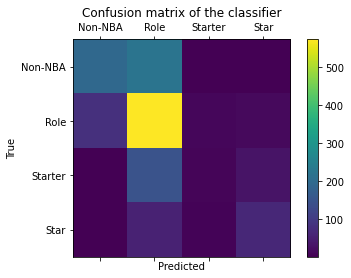

ACS: [0.3924071]
Optimism: -0.023255813953488372


<class 'sklearn.naive_bayes.GaussianNB'>
Best parameters found:
 {'var_smoothing': 0.0657933224657568}
Accuracy: 0.5284972264530238


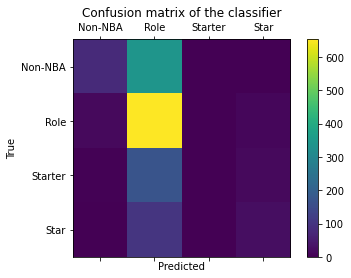

ACS: [0.43906695]
Optimism: 0.03453136011275546


<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Best parameters found:
 {'n_components': 0, 'shrinkage': 'auto', 'solver': 'lsqr', 'store_covariance': True}
Accuracy: 0.5841383946949731


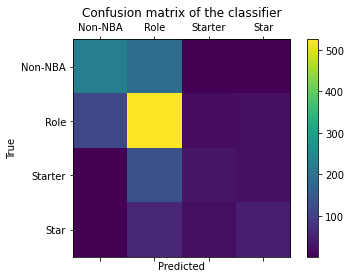

ACS: [0.4667075]
Optimism: 0.09372797744890768


<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
Best parameters found:
 {'reg_param': 0.4, 'store_covariance': True, 'tol': 0.0001}
Accuracy: 0.5147777695488415


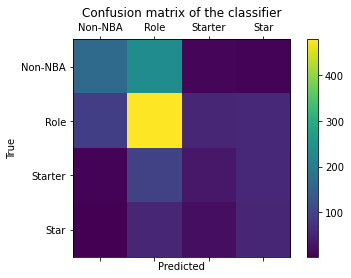

ACS: [0.47605838]
Optimism: 0.2727272727272727


<class 'sklearn.linear_model._logistic.LogisticRegression'>
Best parameters found:
 {'C': 0.01, 'penalty': 'l2'}
Accuracy: 0.5618135429857568


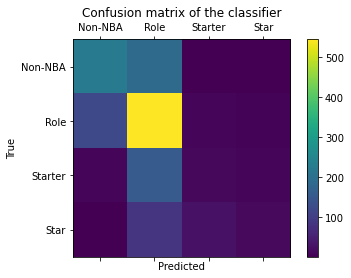

ACS: [0.4493354]
Optimism: -0.18957011980267793


<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best parameters found:
 {'n_neighbors': 20}
Accuracy: 0.5287649792301126


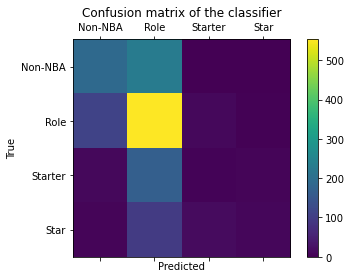

ACS: [0.43240906]
Optimism: -0.10359408033826638


<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best parameters found:
 {'criterion': 'entropy', 'max_depth': 4}
Accuracy: 0.5978806129371385


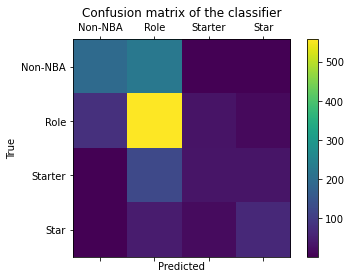

ACS: [0.46641477]
Optimism: -0.019732205778717406


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Best parameters found:
 {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
Accuracy: 0.5693254058593846


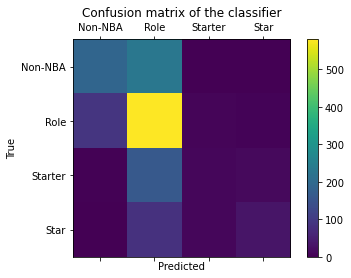

ACS: [0.42543855]
Optimism: -0.22692036645525018


<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Best parameters found:
 {'algorithm': 'SAMME.R', 'base_estimator': RandomForestClassifier(), 'learning_rate': 1.01, 'n_estimators': 20}
Accuracy: 0.5603856355738501


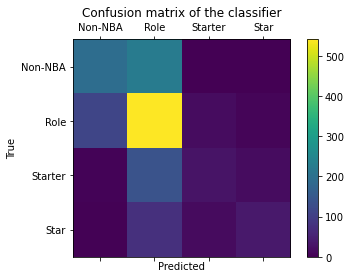

ACS: [0.43104276]
Optimism: -0.1945031712473573


<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Accuracy: 0.5382040801705688


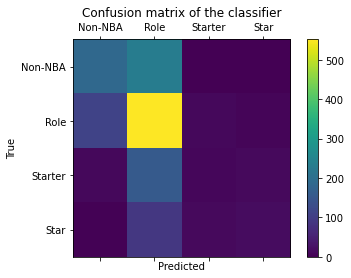

ACS: [0.43391543]
Optimism: -0.10923185341789993




In [6]:
filtered_data = data
for item in models:
    model = item[0]
    params = item[1]
    print(type(model))
    best_model = tune(model, params, filtered_data)
    eval(best_model, filtered_data)
    print()

# Accurate Confidence Score
Accurate Confidence Score is a metric I have created that measures the average confidence a model has in predicting the actual label of the dataset. In mathematical terms:

### ACS = sum(predict_probability[correct label])/ len(dataset)

In [10]:
final_data = base_data.copy()
model = XGBClassifier(objective='multi:softproba',nthread=6,seed=42,verbosity = 0,booster='gbtree', learning_rate= 0.01, max_depth= 2, n_estimators= 180)
predict_data = predict(model, final_data)
names = predict_data.pop('Player')
pick = predict_data.pop('Pick')
year = predict_data.pop('Year')
label = predict_data.pop('Label')
predict_data.insert(0, 'Player', names)
predict_data.insert(1, 'Pick', year)
predict_data.insert(2, 'Year', year)
predict_data.insert(3, 'Label', label)
predict_data = predict_data.sort_values(by=['Star%'], ascending=False)
predict_data = predict_data.sort_values(by=['Year'], ascending=False, kind='stable')
predict_data.to_csv('./result/Predicted.csv',index=False)

In [11]:
train_data = base_data.copy()
train_data.drop('School', axis=1, inplace=True)
train_data.drop('Player', axis=1, inplace=True)
X_train = train_data.loc[:, train_data.columns != 'Label']
y_train = train_data['Label']
predict_data = pd.read_csv('./datasets/2022Prospects.csv')
predict_data = predict_data.fillna(0)
predict_data = predict_data.reindex(np.random.permutation(predict_data.index))
names = predict_data.pop('Player')
school = predict_data.pop('School')

model = XGBClassifier(objective='multi:softproba',nthread=6,seed=42,verbosity = 0,booster='gbtree', learning_rate= 0.01, max_depth= 2, n_estimators= 180)
model.fit(X_train, y_train)
final_prediction = model.predict_proba(predict_data)

NBAe = []
Startere = []
Stare = []
        
for i in range(len(final_prediction)):
        row = final_prediction[i]
        NBAe.append(row[1] + row[2] + row[3])
        Startere.append(row[2] + row[3])
        Stare.append(row[2])

predict_data['School'] = school
predict_data['NBA%'] = NBAe
predict_data['Starter%'] = Startere
predict_data['Star%'] = Stare
year = predict_data.pop('Year')
pick =  predict_data.pop('Pick')
predict_data.insert(0, 'Player', names)
predict_data.insert(1, 'Pick', pick)
predict_data.insert(2, 'Year', year)
predict_data = predict_data.sort_values(by=['Star%'], ascending=False)
predict_data.to_csv('./result/2022Predicted.csv',index=False)

Feature selection

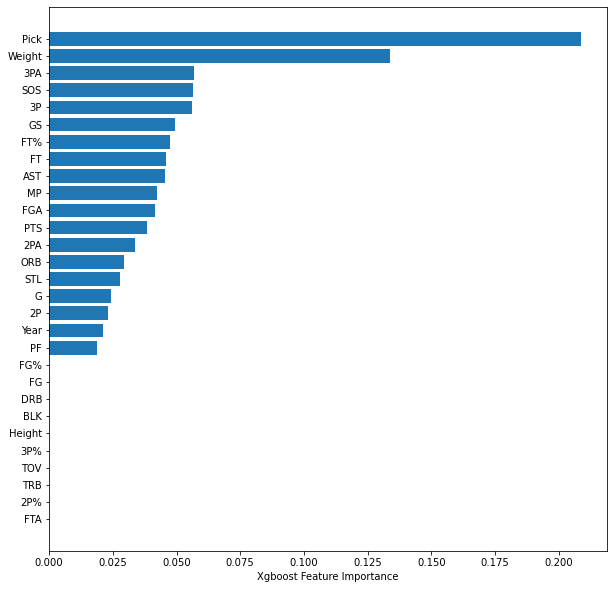

In [12]:
train_data = base_data.copy()
train_data.drop('School', axis=1, inplace=True)
train_data.drop('Player', axis=1, inplace=True)
# train_data.drop('Year', axis=1, inplace=True)
X_train = train_data.loc[:, train_data.columns != 'Label']
y_train = train_data['Label']

xgb_model = XGBClassifier(objective='multi:softproba',nthread=6,seed=42,verbosity = 0,booster='gbtree', learning_rate= 0.01, max_depth= 2, n_estimators= 180)
xgb_model.fit(X_train,y_train)
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

Optimal number of features : 11


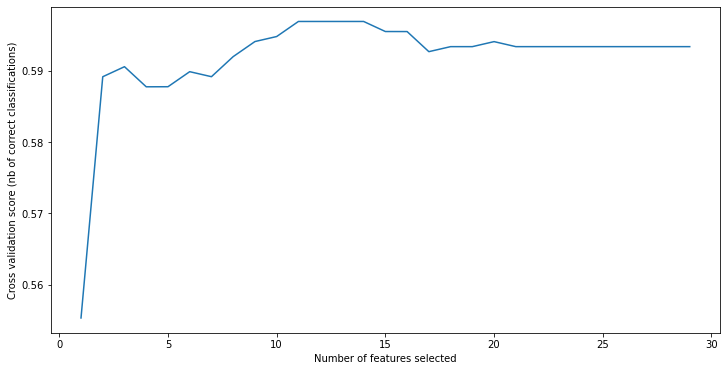

In [13]:
rfecv = RFECV(estimator=XGBClassifier(objective='multi:softproba',nthread=6,seed=42,verbosity = 0,booster='gbtree', learning_rate= 0.01, max_depth= 2, n_estimators= 180))
model = XGBClassifier(objective='multi:softproba',nthread=6,seed=42,verbosity = 0,booster='gbtree', learning_rate= 0.01, max_depth= 2, n_estimators= 180)
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)
pipeline.fit(X_train,y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv.support_rfecv_df.head()

plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()